In [1]:
from pfp_stat import *

import numpy as np
import pandas as pd 

import pandas_datareader.data as web
import matplotlib.pyplot as plt
import matplotlib

import datetime as dat

from pylab import title, figure, xlabel, ylabel, xticks, bar, legend, axis, savefig
from fpdf import FPDF
import fpdf

from pfp_products import *

import os.path
from scipy.optimize import minimize

In [2]:
def mirr(wghts):
    a1 = (payoffs*wghts).sum(axis = 2)    
    a2 = np.ones((a1.shape[0]+1,a1.shape[1]))*(-1)
    a2[1:,:] = a1
    a3 = np.array([np.irr(x) for x in np.transpose(a2)]) 
    return a3

In [3]:
print('Okay, lets see what we have here.')

prodcat_filename = 'inputs/prod_cat open.xlsx'
prodcat_sheetname = 'prod cat'

xls = pd.read_excel(prodcat_filename, prodcat_sheetname, 
                         decimal = '.', usecols = 'b:z', 
                         index_col = 0, header = 1)

print('I`m using `' + prodcat_sheetname + '` sheet of `' + prodcat_filename + '` file as product catalog.')

products = xls.transpose()
all_BAs = []
prod_list = []
max_term = 0

for prod, row in products.iterrows():
    
    check = check_stat(row.BAs)
    
    if check:        
        all_BAs.extend(row.BAs.split(', '))
        all_BAs = list(set(all_BAs))
        
        if row.term > max_term: max_term = row.term

        Note1 = Structure(prod, row.BAs, row.notional_curr, row.term, 
                  row.coupon_value, row.coupon_always, row.coupon_check_months, row.coupon_memory, 
                  row.coupon_lower_barrier, row.coupon_upper_barrier,
                  row.autocall_flag, row.autocall_check_months, row.autocall_barrier, row.autocall_barrier_increase_rate,
                  row.redemption_amount, row.redemption_put_strike, row.redemption_guarantee_rule,
                  row.redemption_upside_participation, row.redemption_downside_participation, row.issuer)
        Note1.stats_ok = True
        
        prod_list.append(Note1)
    else: 
        print ('We dont have enough statistics for ' + row.name + ' underlyings. We do not calculate it now.')

print('...')
print('All products from `prod cat.xls` except mentioned above are successfully loaded.')

Okay, lets see what we have here.
I`m using `prod cat` sheet of `inputs/prod_cat open.xlsx` file as product catalog.
...
All products from `prod cat.xls` except mentioned above are successfully loaded.


In [4]:
n_scenarios = 50000
simulation_years = max_term   

returns = ba_scenarios(all_BAs, 
                       simulation_years,  
                       n_scenarios, 
                       print_statistics = True,
                       points_in_year = 12)
print('Scenarios ready!')

Returns: 
rog sw equity     0.034
alrs rx equity    0.087
yndx rx equity    0.120
solecmvt index    0.020
moex rx equity    0.080
gmkn rx equity    0.080
mtss rx equity    0.092
open pif          0.120
Name: r, dtype: float64
 
Sigmas: 
rog sw equity     0.156097
alrs rx equity    0.278227
yndx rx equity    0.323618
solecmvt index    0.096891
moex rx equity    0.213164
gmkn rx equity    0.191840
mtss rx equity    0.249655
open pif          0.143242
dtype: float32
 
Correlations: 

                rog sw equity  alrs rx equity  yndx rx equity  solecmvt index  \
rog sw equity        1.000000        0.076384       -0.005998        0.011685   
alrs rx equity       0.076384        1.000000        0.522795        0.134812   
yndx rx equity      -0.005998        0.522795        1.000000        0.099164   
solecmvt index       0.011685        0.134812        0.099164        1.000000   
moex rx equity       0.031895        0.468895        0.525695        0.302035   
gmkn rx equity      -0.12411

In [5]:
flag = 1
for prod in prod_list:
    
    print('calculating ' + prod.name)
    
    a1 = prod.payoff(all_BAs, returns, to_pdf = False)
    # a1 - массив размера self.time_steps x n_scenarios
    
    a2 = np.ones((a1.shape[0]+1,a1.shape[1]))*(-1)
    a2[1:,:] = a1
    a3 = np.array([np.irr(x) for x in np.transpose(a2)])
    
    x = a3.std()
    y = a3.mean()
    z = a3.min()

    if flag == 1:
        flag = 0
        payoffs = a1
        irrs = a3
        points1 = [x, y]
        points2 = [z, y]
        
        names = [prod.name]
    else:
        payoffs = np.dstack([payoffs, a1])
        irrs = np.c_[irrs, a3]
        points1 = np.c_[points1, [x, y]]
        points2 = np.c_[points2, [z, y]]
        names.append(prod.name)
print('Done!')

calculating GMKN AM
calculating Rosche AM
calculating Basket coupon
calculating Open PIF
calculating Solars
Done!


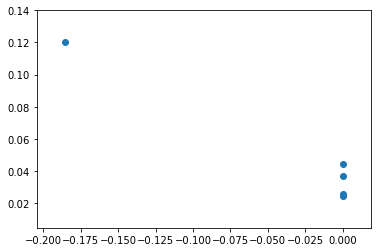

In [6]:
# посмотрим продукты на плоскости риск-доходность:

plt.scatter(points2[0,:], points2[1,:])
plt.show()

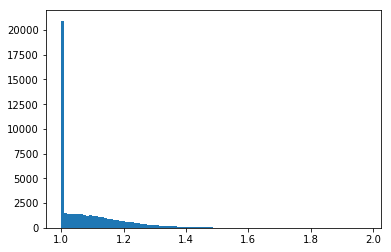

In [7]:
plt.hist(payoffs[:,:,-1].sum(axis = 0), bins = 100)
plt.show()

In [8]:
r1 = returns[-1,:,0]

In [9]:
r1[r1>1].sum()

38643.908672973696

In [10]:
r1[-1,:].sum()

IndexError: too many indices for array

In [ ]:
r1.shape

In [ ]:
p1 = payoffs.shape